In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x207447a03c8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [30]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x160fea13048>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [12]:
# Calculate the date 1 year ago from the last data point in the database

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(prcp, columns = ["date", "precipitation"])
prcp_df.set_index('date', inplace=True)
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [14]:
# Sort the dataframe by date

prcp_df.sort_values("date")

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


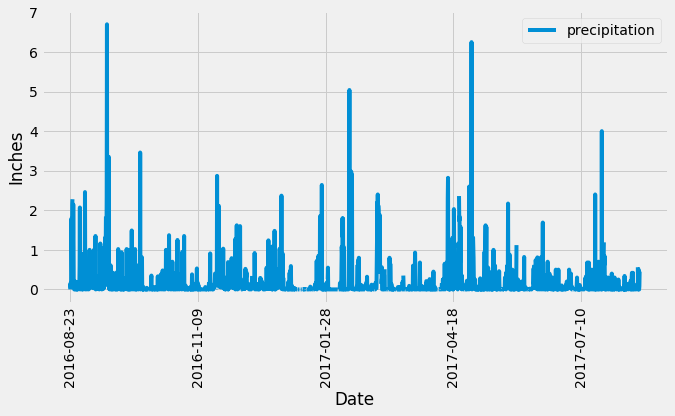

In [35]:
# Use Pandas Plotting with Matplotlib to plot the data

prec_plot = prcp_df.plot(figsize=(10,5))
plt.xticks(rotation = 90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.savefig("Images/precipitation.png")
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [37]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
stations

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

session.query(*temp).filter(Measurement.station=="USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

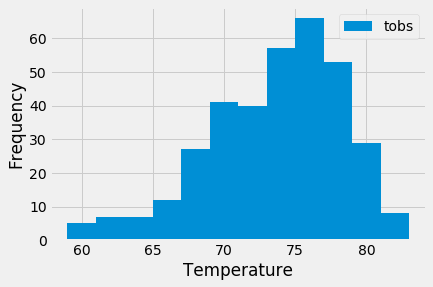

In [40]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_num = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= last_year).all()

tobs_num_df = pd.DataFrame(tobs_num)
#tobs_num_df

plt.hist(tobs_num_df['tobs'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.savefig("Images/station-histogram.png")
plt.show()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

trip_temp = calc_temps('2011-02-28', '2011-03-05')
trip_temp

[(61.0, 69.75510204081633, 75.0)]

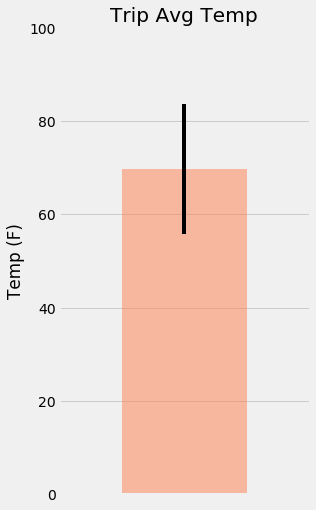

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_data = pd.DataFrame(trip_temp, columns=['tmin', 'tavg', 'tmax' ])
#temp_data

avg_temp = temp_data['tavg']
tdiff = temp_data.iloc[0]['tmax'] - temp_data.iloc[0]['tmin']
#tdiff

avg_temp.plot(kind='bar', yerr=tdiff, figsize=(4,8), alpha=0.5, color='coral')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.ylim(0, 100)
plt.savefig("Images/temperature.png")
plt.show()

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def trip_dates(start_date, end_date):
    
    return session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

rain_total = trip_dates('2011-02-28', '2011-03-05')

rain_df = pd.DataFrame(rain_total, columns=['station', 'prcp', 'name', 'elevation', 'latitude','longitude'])
rain_df

,station,prcp,name,elevation,latitude,longitude
0,USC00518838,2.33,"UPPER WAHIAWA 874.3, HI US",306.6,21.49920,-158.01110
1,USC00519281,2.23,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84889
2,USC00519523,2.19,"WAIMANALO EXPERIMENTAL FARM, HI US",19.5,21.33556,-157.71139
3,USC00514830,1.96,"KUALOA RANCH HEADQUARTERS 886.9, HI US",7.0,21.52130,-157.83740
4,USC00516128,1.45,"MANOA LYON ARBO 785.2, HI US",152.4,21.33310,-157.80250
5,USC00513117,1.44,"KANEOHE 838.1, HI US",14.6,21.42340,-157.80150
6,USC00519397,1.38,"WAIKIKI 717.2, HI US",3.0,21.27160,-157.81680
7,USC00511918,0.63,"HONOLULU OBSERVATORY 702.2, HI US",0.9,21.31520,-157.99920
8,USC00517948,NaN,"PEARL CITY, HI US",11.9,21.39340,-157.97510


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [53]:
# calculate the daily normals for your trip

def daily_normals(date):

    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    daily_normals = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

    return daily_normals

# push each tuple of calculations into a list called `normals`
normals_list = []

# Set the start and end date of the trip
start_date = '2011-02-28'
end_date = '2011-03-05'

# Use the start and end date to create a range of dates

trip_dates = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings

date_mmdd = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for trip_date in date_mmdd:
    normals_list.append(*daily_normals(trip_date))

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
#daily_normals_df

daily_normals_df['Date'] = trip_dates
daily_normals_df = daily_normals_df.set_index('Date')
daily_normals_df


,Tmin,Tavg,Tmax
Date,,,
2011-02-28,65.0,70.655172,80.0
2011-03-01,64.0,70.032787,76.0
2011-03-02,61.0,70.366667,78.0
2011-03-03,60.0,70.068966,78.0
2011-03-04,57.0,69.272727,77.0
2011-03-05,60.0,67.890909,76.0


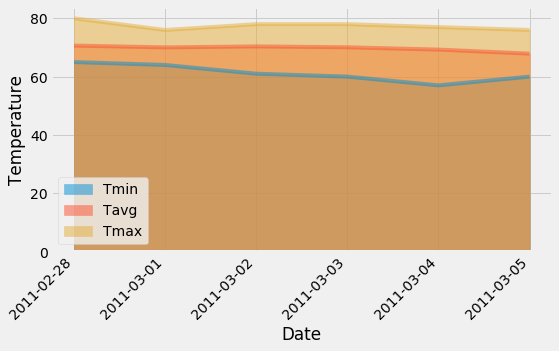

In [74]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', figsize=(8,5), stacked=False, x_compat=True, rot=45)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.savefig("Images/daily_normals.png")
plt.show()